In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt 
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from pyproj import CRS, Transformer
import xarray as xr


# Creating a dataframe with our chosen features for different points and timesteps

In [ ]:
#Import coral data (already transformed)
coral_filepath = '/cluster/home/maikents/midnor_total_coral_data_processed.parquet'
coral_data = pd.read_parquet(coral_filepath)
coral_x = coral_data['x']
coral_y = coral_data['y']


In [ ]:
#Import SINMOD data 

# Load the 4D SINMOD dataset
ds = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc")

#Load the 2D midnor SINMOD dataset to get "gridLons" variable
ds_2d = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc")
gridLons = ds_2d["gridLons"]

#Add gridLons to ds
ds['gridLons'] = gridLons

t_range = 0, len(ds['time'])

#Explore variables in sinmod dataset
print(ds.data_vars.keys())

In [41]:

# Importing SINMOD data
filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'
filename_PhysStates_2d = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc'

PhysStates_data = Dataset(filename_PhysStates, 'r')
PhysStates_data_2d = Dataset(filename_PhysStates_2d, 'r')

gridLons = PhysStates_data_2d.variables['gridLons']

print(gridLons) 

<class 'netCDF4.Variable'>
float32 gridLons(yc, xc)
    SINMODVarID: 22
    units: degrees_east
    standard_name: longitude
    axis: X
    _CoordinateAxisType: Lon
unlimited dimensions: 
current shape = (555, 950)
filling on, default _FillValue of 9.969209968386869e+36 used


In [45]:
# Now make a function to create a dataframe for each feature of interest. Include points at both coral observations, and at random locations. Dimensions: 

def make_dataframe_for_a_feature(netcdf_data, gridLons, coral_data, variable_name, t_range, generate_random=False):

    #Extracting data 
    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0) 

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    hor_res = netcdf_data.variables['grid_mapping'].getncattr('horizontal_resolution')
    t_start, t_stop = t_range

    longitude_of_projection_origin = netcdf_data.variables['grid_mapping'].getncattr('longitude_of_projection_origin')

    # Extract variable values at coral data points
    coral_values = np.full(shape=(len(coral_data['x']), len(range(t_start, t_stop))), fill_value=0.0)
    valid_coordinates = []

    unique_coral_coordinates = list(set(enumerate(zip(coral_data['x']/hor_res, coral_data['y']/hor_res))))
    total_coral_coordinates = list(enumerate(zip(coral_data['x']/hor_res, coral_data['y']/hor_res)))

    zero_count = 0
    zero_coordinates = []

    temp_mask = netcdf_data.variables['temperature'][0, 0].mask
    for i, point in enumerate(zip(coral_data['x']/hor_res, coral_data['y']/hor_res)):
        
        for j, time in enumerate(range(t_start, t_stop)):
            x, y = point
            # Ensure the coordinates are within the grid bounds 
            if (0 <= x <= xc_max and 0 <= y <= yc_max):
                if not temp_mask[int(y), int(x)]:
                    depth_at_point = netcdf_data.variables['depth'][int(y), int(x)] 
                    layer_index = np.searchsorted(cumulative_depth, depth_at_point) 
                    if variable_name == 'current_speed':
                        value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                        if value==0:
                            zero_count += 1
                            zero_coordinates.append((int(x), int(y)))
    
                    elif variable_name == 'statistical_northness' or variable_name == 'statistical_eastness':
                        longitude_at_point = gridLons(int(y), int(x))
                        theta = longitude_at_point - longitude_of_projection_origin
                        eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                        northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                        aspect = np.arctan2(eastward_velocity, northward_velocity)
                        if variable_name == 'statistical_eastness':
                            value = np.sin(aspect)
                            #value = northward_velocity * np.sin(np.deg2rad(90)) + eastward_velocity * np.cos(np.deg2rad(90))
                            if value ==0:
                                    zero_count += 1
                                    zero_coordinates.append((int(x), int(y)))
                        else:
                            value = np.cos(aspect)
                            #value = northward_velocity* np.cos(np.deg2rad(90)) - eastward_velocity * np.sin(np.deg2rad(90))
                            if value ==0:
                                    zero_count +=1
                                    zero_coordinates.append((int(x), int(y)))
                    else:
                        value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]
                        if value ==0:
                                    zero_count +=1
                                    zero_coordinates.append((int(x), int(y)))
    
                    if not np.ma.is_masked(value):
                        coral_values[i, j] = value
                        valid_coordinates.append((int(x), int(y)))
    return coral_values, zero_coordinates

In [ ]:
coral_values_test, zero_coordinates_test = make_dataframe_for_a_feature(PhysStates_data, gridLons, coral_data, 'temperature', t_range, generate_random=False)

print(coral_values_test.shape)


In [127]:
coral_values_test_1, zero_coordinates_test1 = make_dataframe_for_a_feature(PhysStates_data, coral_data, 'current_speed', (5,6), generate_random=False)


xc_max:  950
yc_max:  555
0      564057.588717
1      489906.391851
2      422602.869224
3      509905.682895
4      468580.156219
           ...      
99     489785.216299
100    485256.324608
101    501349.282012
102    426028.261297
103    627261.373088
Name: x, Length: 104, dtype: float64
800.0
800.0


In [128]:
coral_values_test_2, zero_coordinates_test2 = make_dataframe_for_a_feature(PhysStates_data, coral_data, 'current_speed', (139,140), generate_random=False)


xc_max:  950
yc_max:  555
0      564057.588717
1      489906.391851
2      422602.869224
3      509905.682895
4      468580.156219
           ...      
99     489785.216299
100    485256.324608
101    501349.282012
102    426028.261297
103    627261.373088
Name: x, Length: 104, dtype: float64
800.0
800.0


In [129]:

print('zero coordinates test: ', zero_coordinates_test)
print('zero coordinates test1: ', zero_coordinates_test1)
print('zero coordinates test2: ', zero_coordinates_test2)
print('zero count test: ', len(zero_coordinates_test))
print('zero count test1: ', len(zero_coordinates_test1))
print('zero count test2: ', len(zero_coordinates_test2))

zero coordinates test:  []
zero coordinates test1:  [(713, 161), (575, 52), (619, 162), (611, 40), (585, 83), (532, 178), (606, 39), (623, 113), (659, 40), (563, 106), (569, 106), (606, 39), (532, 178)]
zero coordinates test2:  [(713, 161), (575, 52), (619, 162), (611, 40), (585, 83), (532, 178), (606, 39), (623, 113), (659, 40), (563, 106), (569, 106), (606, 39), (532, 178)]
zero count test:  0
zero count test1:  13
zero count test2:  13


In [41]:
def make_dataframe_for_features(netcdf_data, coral_data, variables, t_range, generate_random):
    variables_array = np.full((len(coral_data['x']), len(variables) + 1, len(range(t_range[0], t_range[1]))), 1, dtype=float)


    for i in range(len(variables)):
        variable_values, zero_values = make_dataframe_for_a_feature(netcdf_data, coral_data, variables[i], t_range, generate_random)
        variables_array[:, i, :] = variable_values

    return variables_array
    

#( num pointa, num features + 1, num timesteps)

In [ ]:
variables = ['temperature', 'salinity', 'current_speed', 'statistical_northness', 'statistical_eastness']
coral_df = make_dataframe_for_features(PhysStates_data, coral_data, variables, t_range, generate_random=False)


In [14]:
def sample_random_point(netcdf_data, coral_data, variables, t_range):
    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    t_start, t_stop = t_range

    longitude_of_projection_origin = netcdf_data.variables['grid_mapping'].getncattr('longitude_of_projection_origin')

    # Extract variable values at coral data points
    random_samples = np.full((len(coral_data['x']), len(variables) + 1, len(range(t_range[0], t_range[1]))), 0, dtype=float)
    valid_coordinates = []

    no_points = len(coral_data['x'])

 
    valid_xc_yc_indices = np.argwhere(np.logical_and(~netcdf_data.variables['temperature'][0,0].mask, netcdf_data.variables['depth'][:] <=275,  netcdf_data.variables['depth'][:] >= 150)) 

    selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)] 

    random_valid_coordinates = 0
    for i in range(len(variables)):
        for j, time in enumerate(range(t_start, t_stop)):
            #for k, point  in enumerate(selected_indices):
            correct_samples = 0
            while correct_samples < no_points:
                sample = random.choice(selected_indices)
                x, y = sample
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                    if depth_at_point > 100:
                        random_depth = np.random.uniform(100, depth_at_point)
                    else:
                        random_depth = 100
                    #random_depth = np.random.uniform(100, depth_at_point) 
                    layer_index = np.searchsorted(cumulative_depth, random_depth)

                    if variables[i] == 'current_speed':
                        value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                        if value == 0:
                    elif variables[i] == 'statistical_northness' or variables[i] == 'statistical_eastness':
                        longitude_at_point = netcdf_data.variables['gridLons'][int(y), int(x)]
                        theta = longitude_at_point - longitude_of_projection_origin
                        eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                        northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                        aspect = np.arctan2(eastward_velocity, northward_velocity)
                    
                        if variables[i] == 'statistical_eastness':
                            value = np.sin(aspect)
                            #value = northward_velocity * np.sin(np.deg2rad(90)) + eastward_velocity * np.cos(np.deg2rad(90))

                            if value == 0:
                        else:
                            #value = northward_velocity* np.cos(np.deg2rad(90)) - eastward_velocity * np.sin(np.deg2rad(90))
                            value = np.cos(aspect)
                            if value == 0:
                    
                    else:
                        value = netcdf_data.variables[variables[i]][time, layer_index, int(y), int(x)]
                        if value == 0:

                    if not np.ma.is_masked(value):
                        if variables[i] == ('current_speed' or 'statistical_northness' or 'statistical_eastness'):
                            if not np.ma.is_masked(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]) and not np.ma.is_masked(netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]):
                                random_samples[correct_samples, i, j] = value
                                random_valid_coordinates += 1
                        else:
                            random_samples[correct_samples, i, j] = value
                            random_valid_coordinates += 1

    return random_samples


In [52]:
random_df = sample_random_point_2d(PhysStates_data, coral_data, variables, t_range)


#print(coral_df.shape)
#print(random_df)
#print(random_df[:,0,:])

KeyboardInterrupt: 

In [96]:
for i in range(len(variables)):
    values, counts = np.unique(random_df[:,i,:], return_counts=True)

    #print(counts)
    if np.min(abs(values)) == 0:
        zeroes = counts[0]
    else:
        zeroes = 0

    print(f"Variable {variables[i]} has {zeroes} zeroes")

Variable temperature has 0 zeroes
Variable salinity has 0 zeroes
Variable current_speed has 0 zeroes
Variable statistical_northness has 0 zeroes
Variable statistical_eastness has 0 zeroes


In [135]:
for i in range(len(variables)):
    values, counts = np.unique(coral_df[:,i,:], return_counts=True)

    #print(counts)
    if np.min(abs(values)) == 0:
        zeroes = counts[0]
    else:
        zeroes = 0

    print(f"Variable {variables[i]} has {zeroes} zeroes")

Variable temperature has 6 zeroes


In [42]:
for i in range(len(variables)):
    values, counts = np.unique(random_df[:,i,:], return_counts=True)


    print(f"lowest value for variable: {variables[i]}, {np.min(abs(values))}")

lowest value for variable: temperature, 0.00042724609375
lowest value for variable: salinity, 33.18048858642578
lowest value for variable: current_speed, 0.0006573888240382075
lowest value for variable: statistical_northness, 2.8991982502765984e-05
lowest value for variable: statistical_eastness, 6.492143307585614e-07


In [45]:
combined_array = np.concatenate((coral_df, random_df), axis=0)

print(combined_array.shape)

(208, 6, 10)


In [71]:
functions = [np.mean, np.min, np.max]

combined_df = pd.DataFrame()

variable_functions = {
    'temperature': [np.mean, np.min, np.max],
    'salinity': [np.mean, np.min, np.max],
    'current_speed': [np.mean, np.min, np.max],
    'statistical_northness': [np.mean, np.min, np.max],
    'statistical_eastness': [np.mean, np.min, np.max]
}

for i, key in enumerate(variable_functions.keys()):
    for function in variable_functions[key]:
        combined_df[key + '_' + function.__name__] = function(combined_array[:, i, :], axis=1)


combined_df['labels'] = function(combined_array[:, -1, :], axis=1)


In [136]:
print(coral_df[0,:,:])


[[8.64137745]
 [1.        ]]


In [44]:
functions = [np.mean, np.min, np.max]

coralpoints_df = pd.DataFrame()

variable_functions = {
    'temperature': [np.mean, np.min, np.max],
    'salinity': [np.mean, np.min, np.max],
    'current_speed': [np.mean, np.min, np.max],
    'statistical_northness': [np.mean, np.min, np.max],
    'statistical_eastness': [np.mean, np.min, np.max]
}

for i, key in enumerate(variable_functions.keys()):
    for function in variable_functions[key]:
        print(coral_df[:, i, :].shape)
        print(function(coral_df[:, i, :], axis=1).shape)
        coralpoints_df[key + '_' + function.__name__] = function(coral_df[:, i, :], axis=1)


coralpoints_df['labels'] = function(coral_df[:, -1, :], axis=1)


(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)
(104, 10)
(104,)


In [45]:
coralpoints_df.head()

,temperature_mean,temperature_min,temperature_max,salinity_mean,salinity_min,salinity_max,current_speed_mean,current_speed_min,current_speed_max,statistical_northness_mean,statistical_northness_min,statistical_northness_max,statistical_eastness_mean,statistical_eastness_min,statistical_eastness_max,labels
0,8.765557,8.662007,8.809595,33.824734,33.721931,33.945282,0.233571,0.108745,0.316133,-0.685150,-0.969086,0.190396,0.177007,-0.981707,0.708390,1.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2,8.823878,8.762779,8.890531,33.612357,33.574066,33.627766,0.323594,0.138355,0.461153,-0.625454,-0.962156,-0.094934,0.124748,-0.995484,0.914446,1.0
3,8.838319,8.761192,8.990509,33.324804,33.280678,33.378735,0.423613,0.211944,0.536097,-0.979585,-0.999996,-0.916792,0.118190,-0.102911,0.399366,1.0
4,9.076125,8.977019,9.146031,33.635392,33.570953,33.721931,0.484881,0.204863,0.664479,-0.951657,-0.994382,-0.899165,0.042860,-0.437609,0.361025,1.0


In [46]:
print(np.mean(coral_df, axis=2).shape)
np.mean(coral_df, axis=2)

(104, 6)


array([[ 8.76555681e+00,  3.38247341e+01,  2.33571444e-01,
        -6.85149982e-01,  1.77007491e-01,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 8.82387772e+00,  3.36123569e+01,  3.23593926e-01,
        -6.25453879e-01,  1.24747980e-01,  1.00000000e+00],
       [ 8.83831902e+00,  3.33248035e+01,  4.23613034e-01,
        -9.79585227e-01,  1.18189880e-01,  1.00000000e+00],
       [ 9.07612534e+00,  3.36353924e+01,  4.84880984e-01,
        -9.51657412e-01,  4.28600650e-02,  1.00000000e+00],
       [ 6.76820583e+00,  3.19174673e+01,  6.89837750e-02,
        -3.14317059e-01, -2.48343580e-01,  1.00000000e+00],
       [ 7.76259613e+00,  3.24600449e+01,  1.07182033e-01,
        -7.13882365e-01,  3.18994238e-01,  1.00000000e+00],
       [ 9.18538780e+00,  3.40231022e+01,  5.25208250e-01,
        -9.44869016e-01,  1.30308869e-01,  1.00000000e+00],
       [ 6.66664028e+00,  2.79780296e+01,  1.253

In [34]:
coral_df.shape

(104, 6, 1)

In [47]:
# shuffle samples in dataframe

coralpoints_df = coralpoints_df.sample(frac=1).reset_index(drop=True)
coralpoints_df.head()


,temperature_mean,temperature_min,temperature_max,salinity_mean,salinity_min,salinity_max,current_speed_mean,current_speed_min,current_speed_max,statistical_northness_mean,statistical_northness_min,statistical_northness_max,statistical_eastness_mean,statistical_eastness_min,statistical_eastness_max,labels
0,8.805866,8.785790,8.827846,33.757417,33.749168,33.765511,0.273186,0.182546,0.367636,-0.621242,-0.991062,0.344003,-0.063308,-0.999939,0.669911,1.0
1,7.366570,7.151218,7.554308,31.374969,31.005157,31.654194,0.184041,0.031706,0.452953,0.266802,-0.995298,0.970699,-0.191285,-0.784367,0.977995,1.0
2,7.762596,7.752678,7.772514,32.460045,32.439423,32.475998,0.107182,0.040473,0.217081,-0.713882,-0.995871,-0.117323,0.318994,-0.647200,0.993094,1.0
3,9.185388,9.038911,9.331706,34.023102,33.914150,34.094700,0.525208,0.152960,0.743423,-0.944869,-0.995682,-0.865258,0.130309,-0.336313,0.501326,1.0
4,6.828907,6.798914,6.862392,28.952442,28.602787,29.222252,0.154012,0.063899,0.352265,0.091667,-0.958235,0.861959,-0.190615,-0.992554,0.964445,1.0


In [72]:
# shuffle samples in dataframe

combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df.head()



,temperature_mean,temperature_min,temperature_max,salinity_mean,salinity_min,salinity_max,current_speed_mean,current_speed_min,current_speed_max,statistical_northness_mean,statistical_northness_min,statistical_northness_max,statistical_eastness_mean,statistical_eastness_min,statistical_eastness_max,labels
0,7.791241,7.678885,8.024842,34.718086,34.707939,34.752190,0.055965,0.011282,0.100848,-0.017563,-0.090083,0.052209,0.001246,-0.036327,0.045337,1.0
1,1.651838,-0.928801,4.961210,34.663229,33.774071,34.949799,0.060178,0.010845,0.259304,0.023271,-0.023966,0.167960,-0.009844,-0.086810,0.030765,0.0
2,7.821473,7.762993,7.882809,34.563507,34.555344,34.569839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
3,7.902963,7.870907,7.932005,34.731972,34.727776,34.742271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
4,1.778002,-0.950224,4.301035,34.737466,33.590199,34.961243,0.076072,0.013241,0.473782,-0.043133,-0.253842,0.035896,-0.021976,-0.058109,0.015516,0.0


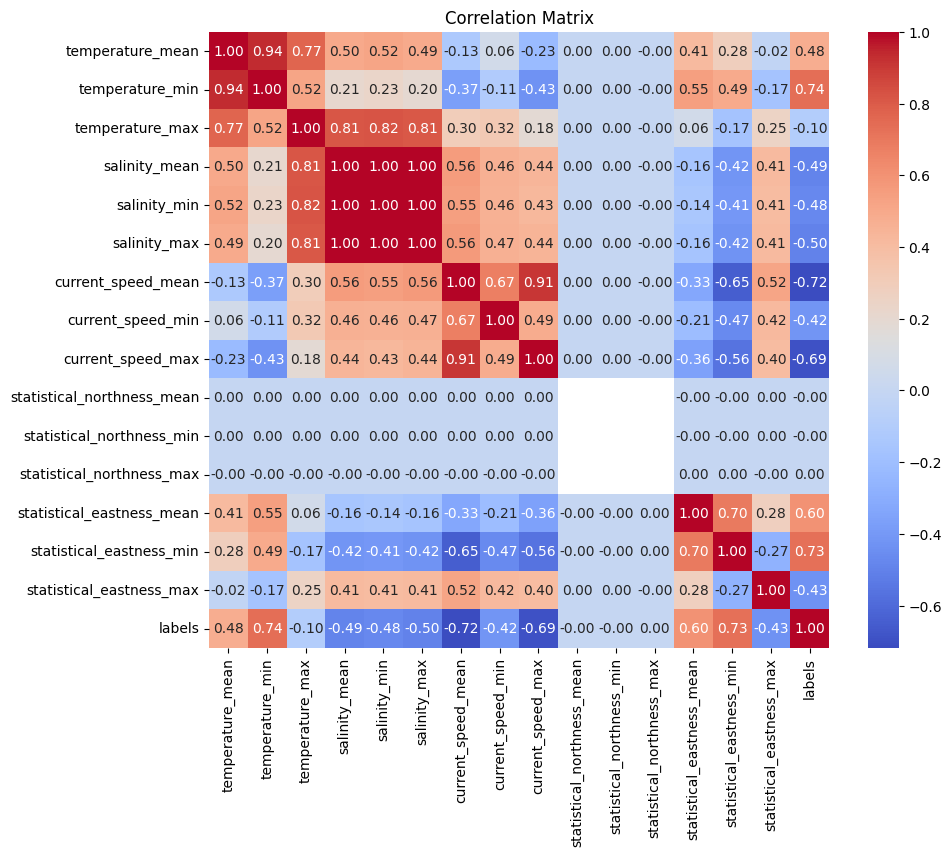

In [75]:
correlation_matrix = combined_df.corr()

correlation_matrix



plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

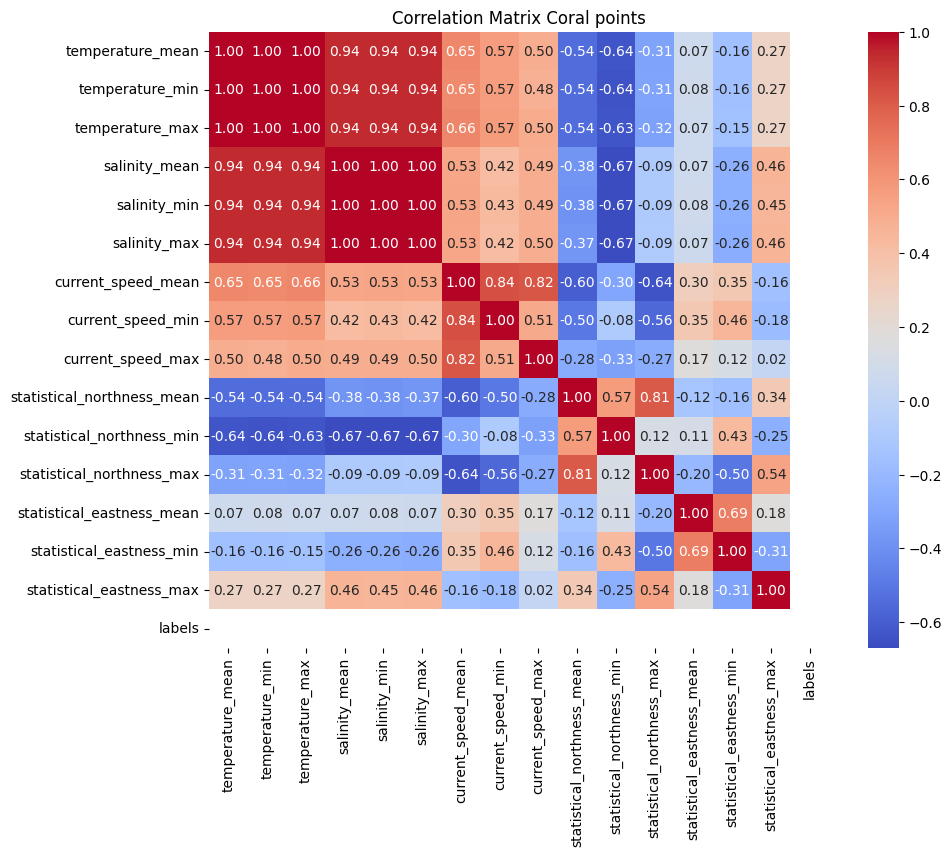

In [48]:
correlation_matrix_coral = coralpoints_df.corr()

correlation_matrix_coral



plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_coral, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Coral points")
plt.show()

In [73]:
scalar = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(combined_df[combined_df.columns[0:-1]], combined_df[combined_df.columns[-1]], test_size=0.2, random_state=42)

print(type(X_train))
X_train = pd.DataFrame(data=scalar.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scalar.transform(X_test), columns=X_test.columns)

<class 'pandas.core.frame.DataFrame'>


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:1156: RuntimeWarning: overflow encountered in square
  temp **= 2
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:84: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


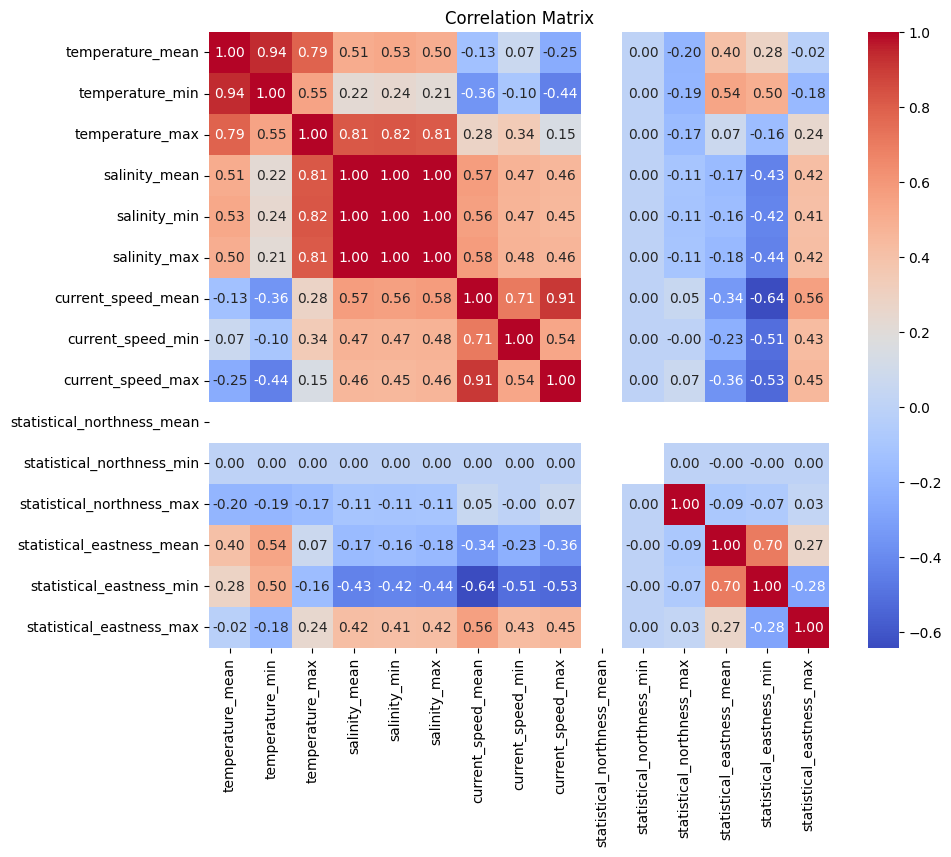

In [78]:
correlation_matrix = X_train.corr()

correlation_matrix



plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [74]:
X_train.head()
y_train.head()

86     0.0
203    0.0
67     0.0
82     1.0
205    0.0
Name: labels, dtype: float64